In [1]:
import pandas as pd
import numpy as np
import timeit
import datetime as dt

In [2]:
import strategy.trendlabeling as tlb

In [3]:
import getdata as gd
import afml.filters.filters as flt 
import afml.labeling.triplebarrier as tbar
import afml.util.volatility as vol
import features.bars as bars  
import features.marketindicators as mkt
import afml.features.fracdiff as fdiff
from afml.ensemble.sb_bagging import SequentiallyBootstrappedBaggingClassifier
from afml.sample_weights.attribution import get_weights_by_return, get_weights_by_time_decay
from afml.feature_importance.importance import mean_decrease_impurity, mean_decrease_accuracy, single_feature_importance, plot_feature_importance
from afml.cross_validation.cross_validation import PurgedKFold, ml_cross_val_score


In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import roc_curve, classification_report, confusion_matrix, accuracy_score

from sklearn.utils import resample
from sklearn.utils import shuffle

## Import Dataset

In [6]:
df_yf = gd.get_yf_data(tickers= "SPY COMP AAPL ALGM DNOW META", 
                    period='1y',   
                    interval='1d')

[*********************100%***********************]  6 of 6 completed


In [7]:
df = df_yf[df_yf['Ticker'] == 'ALGM']
index_SPY = df_yf[df_yf['Ticker'] == 'SPY']
index_COMP = df_yf[df_yf['Ticker'] == 'COMP']

## Get Labels: Trend Scanning method

In [8]:
# convert Adj Close to numpy
time_series = df['Adj Close'].to_numpy()
window_size_max= 7

# get trend scanning labels
label_output = tlb.get_trend_scanning_labels(time_series=time_series, 
                                             window_size_max=window_size_max, 
                                             threshold=0.0,
                                             opp_sign_ct=3,
                                             side='up')

# drop last rolling window size -1 rows
n = window_size_max-1
#df.drop(df.tail(n).index, inplace = True)
df = df.iloc[:-n]

# append the slope and labels to the df
df['slope'] = label_output['slope']
df['label'] = label_output['label']
# df['isEvent'] = label_output['isEvent']
# isEvent = df[df['isEvent']==1].index

## Get Labels: Simple moving average cross over strategy

In [9]:
# need to cite here ...

# compute moving averages
fast_window = 20
slow_window = 50

df['fast_mavg'] = df['Adj Close'].rolling(window=fast_window, min_periods=fast_window, center=False).mean()
df['slow_mavg'] = df['Adj Close'].rolling(window=slow_window, min_periods=slow_window, center=False).mean()
df.head()

# Compute sides
df['side'] = np.nan

long_signals = df['fast_mavg'] >= df['slow_mavg'] 
short_signals = df['fast_mavg'] < df['slow_mavg'] 
df.loc[long_signals, 'side'] = 1
df.loc[short_signals, 'side'] = -1

# Remove Look ahead biase by lagging the signal
df['side'] = df['side'].shift(1)

## Raw Data 

In [10]:
# Save the raw data
raw_data = df.drop(columns='Close').copy()

# Drop the NaN values from our data set
df.dropna(axis=0, how='any', inplace=True)

In [11]:
print(df['label'].value_counts())
print(df['side'].value_counts())

 1    109
-1     86
Name: label, dtype: int64
 1.0    114
-1.0     81
Name: side, dtype: int64


## Form Dollar Bars

In [12]:
# construct the input data
_df = df.reset_index()
trades = _df[['Date', 'Adj Close', 'Volume']].to_numpy()

# define the dollar value to sample the data
frequency = _df.Volume.mean()*20

# generate the dollar bars
dollar_bars = bars.generate_dollarbars(trades, frequency=frequency) 

# define closing price
close = dollar_bars.close.copy()

## Filter Events using CUSUM Filter

We will then predict what will happen if the event is triggered, based on the 'side' signal from the Trend Following Strategy 

In [13]:
# get Daily Volatility
dailyVolatility = vol.getDailyVol(close, span=50)

# apply cusum filter to identify events as cumulative log return passed threshold
tEvents = flt.getTEvents(close, h=dailyVolatility.mean())

# Define vertical barrier - subjective judgment
num_days = 10

t1 = tbar.add_vertical_barrier(tEvents, close, num_days=num_days)

In [14]:
# get side labels from trend following method
side_labels = []

for dt in dollar_bars.index:
    side_labels.append(df.loc[dt]['label'])

side_labels = pd.Series(side_labels, index=dollar_bars.index)

## Create Trade or Not Trade labels using Triple Barrier Method

In [15]:
# Define upper and lower horizontal barriers
# set profit and stop loss ratio
ptsl = [2,1]

# select minRet
minRet = 0.01 # requires at least 1 percent return

# Run in single-threaded mode on Windows
import platform, os
if platform.system() == "Windows":
    cpus = 1
else:
    cpus = os.cpu_count() - 1
    
events = tbar.get_events(dollar_bars.close, 
                         t_events=tEvents[1:], 
                         pt_sl=ptsl, 
                         target=dailyVolatility, 
                         min_ret=minRet, 
                         num_threads=cpus, 
                         vertical_barrier_times=t1,
                         side_prediction=side_labels).dropna()



c:\Users\Elaine Chao\OneDrive\Coursera\Capstone\MADS_Capstone\afml\labeling\triplebarrier.py:50: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for loc, vertical_barrier in events_['t1'].fillna(close.index[-1]).iteritems():


In [16]:
labels = tbar.get_bins(triple_barrier_events = events, close=close)

print(labels.bin.value_counts())

0    81
1    29
Name: bin, dtype: int64


In [17]:
# Drop underpopulated labels
clean_labels  = tbar.drop_labels(labels)

print(clean_labels.bin.value_counts())

0    81
1    29
Name: bin, dtype: int64


In [18]:
clean_labels[clean_labels['bin']==1]

,ret,trgt,bin,side
2022-06-06,0.127532,0.032992,1,-1.0
2022-06-10,0.130777,0.031137,1,-1.0
2022-06-14,0.067847,0.029549,1,-1.0
2022-06-24,0.091696,0.035554,1,-1.0
2022-07-14,0.109012,0.037594,1,1.0
2022-07-18,0.093123,0.037128,1,1.0
2022-07-21,0.110092,0.047630,1,1.0
2022-07-26,0.117462,0.045970,1,1.0
2022-07-27,0.119715,0.046368,1,1.0
2022-08-25,0.159039,0.051929,1,-1.0


## Results of Primary Model without features

In [19]:
primary_forecast = pd.DataFrame(clean_labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

# Performance Metrics
actual = primary_forecast['actual']
pred = primary_forecast['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        81
           1       0.26      1.00      0.42        29

    accuracy                           0.26       110
   macro avg       0.13      0.50      0.21       110
weighted avg       0.07      0.26      0.11       110

Confusion Matrix
[[ 0 81]
 [ 0 29]]

Accuracy
0.2636363636363636


c:\Users\Elaine Chao\OneDrive\Coursera\Capstone\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Elaine Chao\OneDrive\Coursera\Capstone\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Elaine Chao\OneDrive\Coursera\Capstone\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

#### Fitting a Meta model

Use features: volatility, serial correlation, relative strength to S&P

In [20]:
# Save the raw data
raw_data = df.drop(columns='Close').copy()

raw_data.head()

,Ticker,Adj Close,High,Low,Open,Volume,slope,label,fast_mavg,slow_mavg,side
Date,,,,,,,,,,,
2022-05-31,ALGM,25.750000,25.920000,24.820000,25.379999,1080000,-0.015,-1,24.2155,25.4100,-1.0
2022-06-01,ALGM,25.350000,26.287001,25.110001,26.030001,1429800,-0.135,-1,24.1960,25.3296,-1.0
2022-06-02,ALGM,25.719999,25.930000,25.250000,25.360001,914000,-0.287,-1,24.1635,25.2626,-1.0
2022-06-03,ALGM,25.080000,25.490000,24.650000,25.139999,539900,-0.060,-1,24.1295,25.1980,-1.0
2022-06-06,ALGM,24.490000,25.525000,24.139999,25.340000,764700,-0.010,-1,24.0895,25.1014,-1.0


#### Features

In [21]:
# Log Returns
raw_data['log_ret'] = np.log(raw_data['Adj Close']).diff()

# Momentum
raw_data['mom1'] = raw_data['Adj Close'].pct_change(periods=1)
raw_data['mom2'] = raw_data['Adj Close'].pct_change(periods=2)
raw_data['mom3'] = raw_data['Adj Close'].pct_change(periods=3)
raw_data['mom4'] = raw_data['Adj Close'].pct_change(periods=4)
raw_data['mom5'] = raw_data['Adj Close'].pct_change(periods=5)

# Volatility
raw_data['volatility_50'] = raw_data['log_ret'].rolling(window=50, min_periods=1, center=False).std()
raw_data['volatility_31'] = raw_data['log_ret'].rolling(window=31, min_periods=1, center=False).std()
raw_data['volatility_15'] = raw_data['log_ret'].rolling(window=15, min_periods=1, center=False).std()

# Serial Correlation (Takes about 4 minutes)
window_autocorr = 50

raw_data['autocorr_1'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=3, center=False).apply(lambda x: x.autocorr(lag=1), raw=False)
raw_data['autocorr_2'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=3, center=False).apply(lambda x: x.autocorr(lag=2), raw=False)
raw_data['autocorr_3'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=3, center=False).apply(lambda x: x.autocorr(lag=3), raw=False)
raw_data['autocorr_4'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=3, center=False).apply(lambda x: x.autocorr(lag=4), raw=False)
raw_data['autocorr_5'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=3, center=False).apply(lambda x: x.autocorr(lag=5), raw=False)

# Get the various log -t returns
raw_data['log_t1'] = raw_data['log_ret'].shift(1)
raw_data['log_t2'] = raw_data['log_ret'].shift(2)
raw_data['log_t3'] = raw_data['log_ret'].shift(3)
raw_data['log_t4'] = raw_data['log_ret'].shift(4)
raw_data['log_t5'] = raw_data['log_ret'].shift(5)

c:\Users\Elaine Chao\OneDrive\Coursera\Capstone\env\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\Elaine Chao\OneDrive\Coursera\Capstone\env\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\Elaine Chao\OneDrive\Coursera\Capstone\env\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\Elaine Chao\OneDrive\Coursera\Capstone\env\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)


In [22]:
# # Re compute sides
# raw_data['side'] = np.nan

# long_signals = raw_data['fast_mavg'] >= raw_data['slow_mavg']
# short_signals = raw_data['fast_mavg'] < raw_data['slow_mavg']

# raw_data.loc[long_signals, 'side'] = 1
# raw_data.loc[short_signals, 'side'] = -1

In [23]:
# Remove look ahead bias
raw_data = raw_data.shift(1)

In [24]:
raw_data.columns

Index(['Ticker', 'Adj Close', 'High', 'Low', 'Open', 'Volume', 'slope',
       'label', 'fast_mavg', 'slow_mavg', 'side', 'log_ret', 'mom1', 'mom2',
       'mom3', 'mom4', 'mom5', 'volatility_50', 'volatility_31',
       'volatility_15', 'autocorr_1', 'autocorr_2', 'autocorr_3', 'autocorr_4',
       'autocorr_5', 'log_t1', 'log_t2', 'log_t3', 'log_t4', 'log_t5'],
      dtype='object')

In [25]:
# serial correlation
srl_corr = mkt.df_rolling_autocorr(mkt.returns(close), window=7).rename('srl_corr')

# relative strength to SPY
rs_SPY = mkt.get_relative_strength(df['Adj Close'], index_SPY['Adj Close']).shift(1).dropna()


In [26]:
# fractional differentiated log dollar bar prices

# cumulative sum of stock log-prices
ticker_log_cumsum = np.log(dollar_bars.close).cumsum()

# frac diff 1 time
dfx1 = fdiff.frac_diff_ffd(ticker_log_cumsum.to_frame(), diff_amt=1).dropna()

# apply cumsum filter
dfx1_close = dfx1.close.copy()
df_tEvents = flt.getTEvents(dfx1_close, h=dfx1.std().iat[0]*2)

# fracDiff value feature
frac_diff_feat = dfx1.loc[df_tEvents] 


In [27]:
features = (pd.DataFrame()
            .assign(vol=events.trgt)
            #.assign(side=clean_labels.side)
            #.assign(srl_corr=srl_corr)
            .assign(rs_SPY=rs_SPY)
            #.assign(frac_diff_feat=frac_diff_feat)
            .drop_duplicates()
            .dropna())

In [28]:
# Get features at event dates
_X = raw_data.loc[clean_labels.index, :]

In [29]:
# Drop unwanted columns
_X.drop(['Ticker',
        'Adj Close', 'High', 'Low', 'Open', 'Volume', 
        #'fast_mavg', 'slow_mavg', 'side', # remove for MA crossover
        #'slope', 'label', # remove for trend scanning
        ], axis=1, inplace=True)

In [30]:
Xy = _X.join(features).join(clean_labels['bin']).dropna()

In [31]:
X = Xy.iloc[:, :-1]
y = Xy.iloc[:, -1]

In [32]:
y.value_counts()

0    81
1    28
Name: bin, dtype: int64

In [33]:
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=False)

In [34]:
Xy.columns

Index(['slope', 'label', 'fast_mavg', 'slow_mavg', 'side', 'log_ret', 'mom1',
       'mom2', 'mom3', 'mom4', 'mom5', 'volatility_50', 'volatility_31',
       'volatility_15', 'autocorr_1', 'autocorr_2', 'autocorr_3', 'autocorr_4',
       'autocorr_5', 'log_t1', 'log_t2', 'log_t3', 'log_t4', 'log_t5', 'vol',
       'rs_SPY', 'bin'],
      dtype='object')

## Sample Weights

In [35]:
return_based_sample_weights = get_weights_by_return(events.loc[X_train.index], df.loc[X_train.index, 'Adj Close'])
time_based_sample_weights = get_weights_by_time_decay(events.loc[X_train.index], df.loc[X_train.index, 'Adj Close'], decay=0.5)

2023-03-20 01:37:44.857749 100.0% num_concurrent_events done after 0.01 minutes. Remaining 0.0 minutes.
2023-03-20 01:37:45.458299 100.0% _apply_weight_by_return done after 0.01 minutes. Remaining 0.0 minutes.
2023-03-20 01:37:46.061249 100.0% num_concurrent_events done after 0.01 minutes. Remaining 0.0 minutes.
2023-03-20 01:37:46.690598 100.0% _get_average_uniqueness done after 0.01 minutes. Remaining 0.0 minutes.


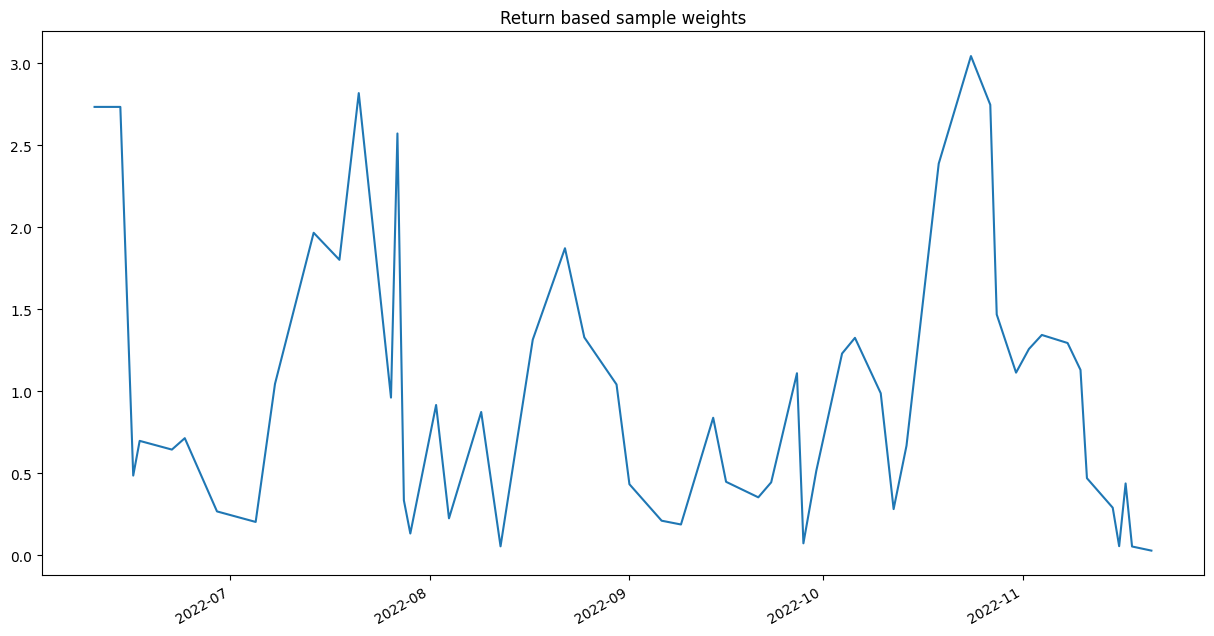

In [36]:
plt.figure(figsize=(10,4))
plt.title('Return based sample weights')
return_based_sample_weights.plot()
plt.show()

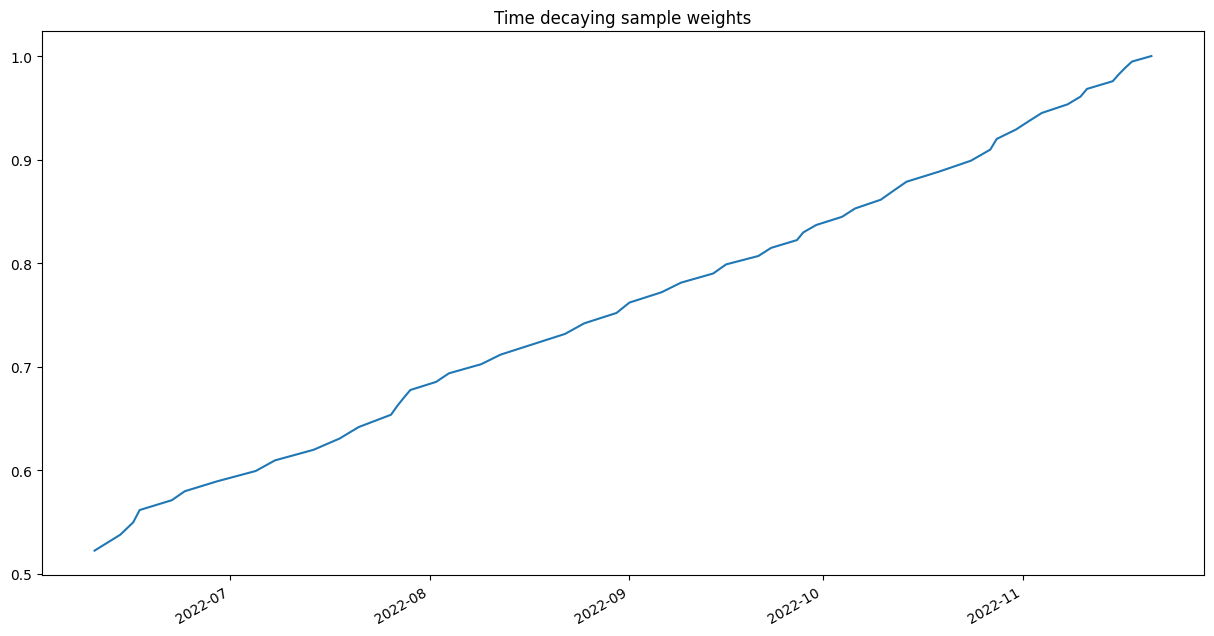

In [37]:
plt.figure(figsize=(10,4))
plt.title('Time decaying sample weights')
time_based_sample_weights.plot()
plt.show()

## Cross-Validation 

In [38]:
parameters = {'max_depth':[2, 3, 4, 5, 7],
              'n_estimators':[10, 25, 50, 100, 256, 512]}

In [39]:
cv_gen_standard = KFold(4)
cv_gen_purged = PurgedKFold(n_splits=4, samples_info_sets=events.loc[X_train.index].t1)

In [40]:
def perform_grid_search(X_data, y_data, cv_gen, scoring, type='standard'):
    """
    Grid search using Purged CV without using sample weights in fit(). Returns top model and top score
    """
    max_cross_val_score = -np.inf
    top_model = None
    for m_depth in parameters['max_depth']:
        for n_est in parameters['n_estimators']:
            clf_base = DecisionTreeClassifier(criterion='entropy', random_state=42, 
                                              max_depth=m_depth, class_weight='balanced')
            clf_bagging = BaggingClassifier(n_estimators=n_est, 
                                        estimator=clf_base, 
                                        random_state=42, n_jobs=-1, 
                                        oob_score=False, max_features=1.)
            clf_random_forest = RandomForestClassifier(n_estimators=n_est, 
                                             max_depth=m_depth, 
                                             random_state=42, 
                                             n_jobs=-1, 
                                             oob_score=False, 
                                            criterion='entropy',
                                            class_weight='balanced_subsample', 
                                            max_features=1.)

            if type == 'standard':
                clf = clf_bagging
            elif type == 'random_forest':
                clf = clf_random_forest
            elif type == 'sequential_bootstrapping':
                clf = SequentiallyBootstrappedBaggingClassifier(samples_info_sets=events.loc[X_train.index].t1, ## events
                                                                price_bars = dollar_bars.loc[X_train.index.min():X_train.index.max(), 'close'], ## df
                                                                n_estimators=n_est, estimator=clf_base, 
                                                                random_state=42, n_jobs=-1, oob_score=False,
                                                                max_features=1.)
            temp_score_base = ml_cross_val_score(clf, X_data, y_data, cv_gen, scoring=scoring)
            if temp_score_base.mean() > max_cross_val_score:
                max_cross_val_score = temp_score_base.mean()
                print(temp_score_base.mean())
                top_model = clf
    return top_model, max_cross_val_score

In [41]:
def perform_grid_search_sample_weights(X_data, y_data, cv_gen, scoring, type='standard'):
    """
    Grid search using Purged CV using sample weights in fit(). Returns top model and top score
    """
    max_cross_val_score = -np.inf
    top_model = None
    for m_depth in parameters['max_depth']:
        for n_est in parameters['n_estimators']:
            clf_base = DecisionTreeClassifier(criterion='entropy', random_state=42, 
                                              max_depth=m_depth, class_weight='balanced')
            clf_bagging = BaggingClassifier(n_estimators=n_est, 
                                        estimator=clf_base, 
                                        random_state=42, n_jobs=-1, 
                                        oob_score=False, max_features=1.)
            clf_random_forest = RandomForestClassifier(n_estimators=n_est, 
                                             max_depth=m_depth, 
                                             random_state=42, 
                                             n_jobs=-1, 
                                             oob_score=False, 
                                            criterion='entropy',
                                            class_weight='balanced_subsample', 
                                            max_features=1.)

            if type == 'standard':
                clf = clf_bagging
            elif type == 'random_forest':
                clf = clf_random_forest
            elif type == 'sequential_bootstrapping':
                clf = SequentiallyBootstrappedBaggingClassifier(samples_info_sets=events.loc[X_train.index].t1, #events
                                                                price_bars = dollar_bars.loc[X_train.index.min():X_train.index.max(), 'close'], #df
                                                                n_estimators=n_est, estimator=clf_base, 
                                                                random_state=42, n_jobs=-1, oob_score=False,
                                                                max_features=1.)
            temp_score_base = ml_cross_val_score(clf, X_data, y_data, cv_gen, scoring=scoring,
                                                                    sample_weight=return_based_sample_weights.values)
            if temp_score_base.mean() > max_cross_val_score:
                max_cross_val_score = temp_score_base.mean()
                print(temp_score_base.mean())
                top_model = clf
    return top_model, max_cross_val_score

In [42]:
top_model, cross_val_score = perform_grid_search(X_train, y_train, cv_gen_purged, 'f1', type = 'standard')
print(top_model, cross_val_score)

0.13942307692307693
0.15476190476190477
0.18333333333333335
BaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                   criterion='entropy',
                                                   max_depth=3,
                                                   random_state=42),
                  n_jobs=-1, random_state=42) 0.18333333333333335


In [43]:
top_model, cross_val_score = perform_grid_search_sample_weights(X_train, y_train, cv_gen_purged, 'f1', type = 'standard')
print(top_model, cross_val_score)

0.04441878512309789
0.12512892838710044
BaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                   criterion='entropy',
                                                   max_depth=2,
                                                   random_state=42),
                  n_estimators=25, n_jobs=-1, random_state=42) 0.12512892838710044


In [44]:
top_model, cross_val_score = perform_grid_search(X_train, y_train, cv_gen_purged, 'f1', type = 'random_forest')
print(top_model, cross_val_score)

0.11309523809523811
0.15476190476190477
RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=2, max_features=1.0, n_estimators=25,
                       n_jobs=-1, random_state=42) 0.15476190476190477


In [45]:
top_model, cross_val_score = perform_grid_search_sample_weights(X_train, y_train, cv_gen_purged, 'f1', type = 'random_forest')
print(top_model, cross_val_score)

0.10000069471985468
0.12512892838710044
RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=2, max_features=1.0, n_estimators=25,
                       n_jobs=-1, random_state=42) 0.12512892838710044


In [46]:
import warnings
warnings.filterwarnings('ignore')

In [47]:
top_model, cross_val_score = perform_grid_search(X_train, y_train, cv_gen_purged, 'f1', type = 'sequential_bootstrapping')
print(top_model, cross_val_score)

0.08333333333333333
SequentiallyBootstrappedBaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                           criterion='entropy',
                                                                           max_depth=2,
                                                                           random_state=42),
                                          n_jobs=-1,
                                          price_bars=time
2022-06-10    23.000000
2022-06-14    21.719999
2022-06-16    20.340000
2022-06-17    20.719999
2022-06-22    20.799999
2022-06-24    21.430000
2022-06-29    20.889999
2022-07-05    19.629999
2022-07-08    20.389999
2022-0...
2022-10-12   2022-10-24
2022-10-14   2022-10-24
2022-10-19   2022-10-27
2022-10-24   2022-10-28
2022-10-27   2022-11-07
2022-10-28   2022-11-07
2022-10-31   2022-11-10
2022-11-02   2022-11-11
2022-11-04   2022-11-14
2022-11-08   2022-11-15
2022-11-10   2022-11-21
20

In [48]:
top_model, cross_val_score = perform_grid_search_sample_weights(X_train, y_train, cv_gen_purged, 'f1', type = 'sequential_bootstrapping')
print(top_model, cross_val_score)

0.1690465730494407
SequentiallyBootstrappedBaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                           criterion='entropy',
                                                                           max_depth=2,
                                                                           random_state=42),
                                          n_jobs=-1,
                                          price_bars=time
2022-06-10    23.000000
2022-06-14    21.719999
2022-06-16    20.340000
2022-06-17    20.719999
2022-06-22    20.799999
2022-06-24    21.430000
2022-06-29    20.889999
2022-07-05    19.629999
2022-07-08    20.389999
2022-0...
2022-10-12   2022-10-24
2022-10-14   2022-10-24
2022-10-19   2022-10-27
2022-10-24   2022-10-28
2022-10-27   2022-11-07
2022-10-28   2022-11-07
2022-10-31   2022-11-10
2022-11-02   2022-11-11
2022-11-04   2022-11-14
2022-11-08   2022-11-15
2022-11-10   2022-11-21
202

## Feature Importance

In [49]:
# MDI, MDA, SFI feature importance
mdi_feat_imp = mean_decrease_impurity(top_model, X_train.columns)
mda_feat_imp = mean_decrease_accuracy(top_model, X_train, y_train, cv_gen_purged, scoring='f1', 
                                                         sample_weight=return_based_sample_weights.values)
sfi_feat_imp = single_feature_importance(top_model, X_train, y_train, cv_gen_purged, scoring='f1',
                                     sample_weight=return_based_sample_weights.values)

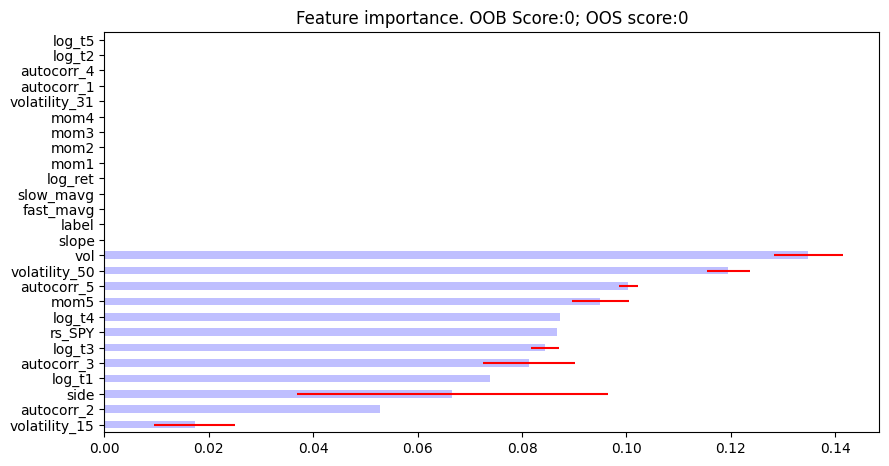

In [50]:
plot_feature_importance(mdi_feat_imp, 0, 0)

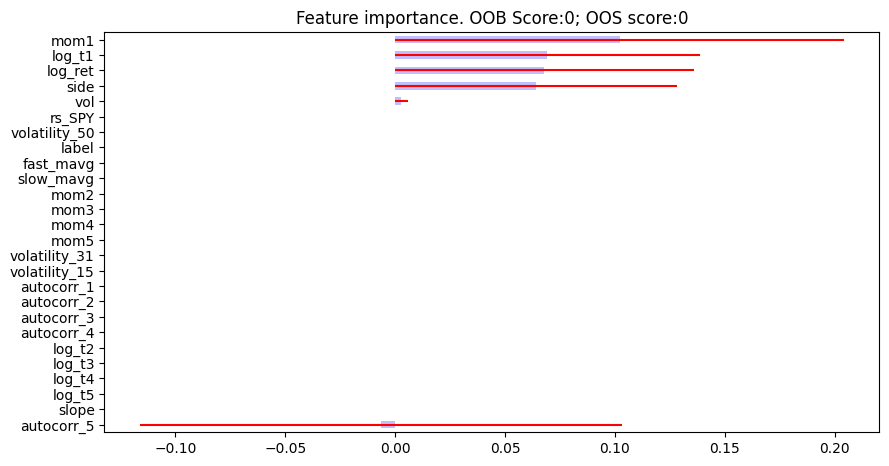

In [51]:
plot_feature_importance(mda_feat_imp, 0, 0)

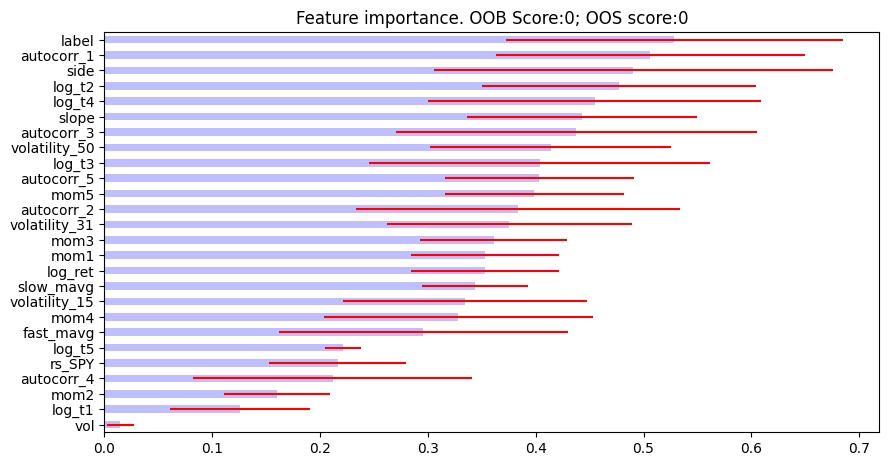

In [52]:
plot_feature_importance(sfi_feat_imp, 0, 0)

## Fitting Top Model

              precision    recall  f1-score   support

           0       0.57      0.10      0.16        42
           1       0.21      0.77      0.33        13

    accuracy                           0.25        55
   macro avg       0.39      0.43      0.25        55
weighted avg       0.49      0.25      0.20        55

[[ 4 38]
 [ 3 10]]
0.2545454545454545


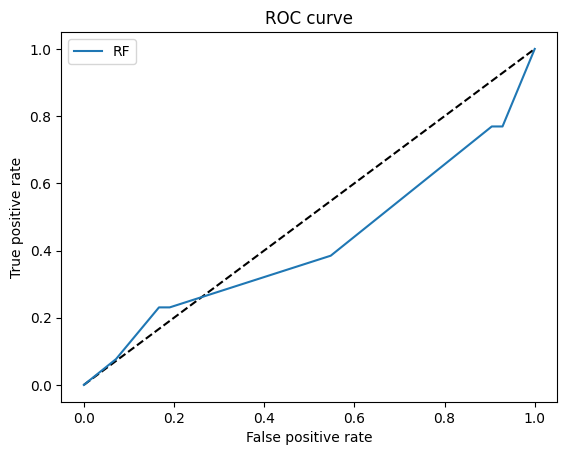

In [53]:
y_pred_rf = top_model.predict_proba(X_test)[:, 1]
y_pred = top_model.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [54]:
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=False)

              precision    recall  f1-score   support

           0       0.77      0.88      0.82        42
           1       0.29      0.15      0.20        13

    accuracy                           0.71        55
   macro avg       0.53      0.52      0.51        55
weighted avg       0.66      0.71      0.68        55

[[37  5]
 [11  2]]
0.7090909090909091


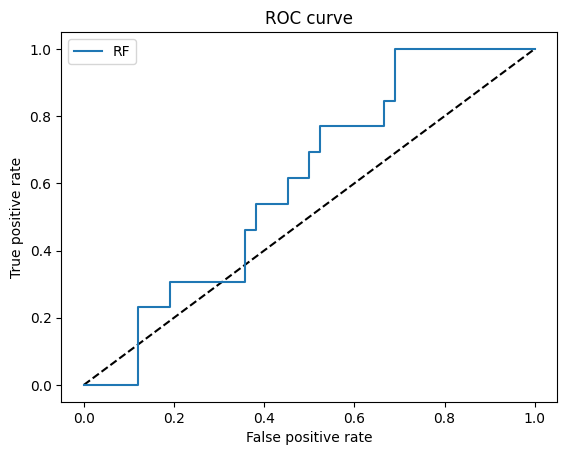

In [58]:
n_estimator = 10000
rf = RandomForestClassifier(max_depth=2, 
                            n_estimators=n_estimator,
                            criterion='entropy', 
                            class_weight='balanced',
                            random_state=RANDOM_STATE)
rf.fit(X_train, y_train)

# The random forest model by itself
y_pred_rf = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [56]:
top_model

SequentiallyBootstrappedBaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                           criterion='entropy',
                                                                           max_depth=2,
                                                                           random_state=42),
                                          n_jobs=-1,
                                          price_bars=time
2022-06-10    23.000000
2022-06-14    21.719999
2022-06-16    20.340000
2022-06-17    20.719999
2022-06-22    20.799999
2022-06-24    21.430000
2022-06-29    20.889999
2022-07-05    19.629999
2022-07-08    20.389999
2022-0...
2022-10-12   2022-10-24
2022-10-14   2022-10-24
2022-10-19   2022-10-27
2022-10-24   2022-10-28
2022-10-27   2022-11-07
2022-10-28   2022-11-07
2022-10-31   2022-11-10
2022-11-02   2022-11-11
2022-11-04   2022-11-14
2022-11-08   2022-11-15
2022-11-10   2022-11-21
2022-11-11   2022-11-21
2022-11-15   2022-11-23
2022-11-16   2022-11-23
2022-11-17   2022-11-28
2022-11-18   2022-11-28
2022-11-21   2022-12-01
Name: t1, dtype: datetime64[ns])

## Backtest

In [57]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)